In [2]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2023-07-26 05:47:17--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  35.6MB/s    in 2.3s    

2023-07-26 05:47:20 (35.6 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [3]:
import tensorflow as tf
from tensorflow import keras

# 텍스트 파일로 데이터셋 만들기
dataset = keras.utils.text_dataset_from_directory(
        directory = 'aclImdb', label_mode = None, batch_size = 256)
dataset = dataset.map(lambda x : tf.strings.regex_replace(x, "<br />", " "))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Found 100006 files belonging to 1 classes.


In [4]:
# 어휘 사전 생성 : TextVectorizer 이용, 15000개 단어만 사용.
from tensorflow.keras.layers import TextVectorization

sequence_length = 100
voca_size = 15000 # 가장 자주 등장하는 15000개만 사용, 나머지는 OOV 토큰 [UNK]
text_vectorization = TextVectorization(
    max_tokens = voca_size,
    output_mode = 'int', # 정수 단어 인덱스의 시퀀스
    output_sequence_length = sequence_length, # 길이 100인 입력과 타깃. 타깃은 한 스텝 차이가 나므로 실제로 모델은 99개를 봄
)
text_vectorization.adapt(dataset)

In [5]:
# 언어 모델링 데이터셋 : 입력 샘플은 벡터화된 텍스트, 타깃은 한 스텝 앞의 동일 텍스트.
def prepare_lm_dataset(text_batch):
    vectorized_sequences = text_vectorization(text_batch)
    x = vectorized_sequences[:, :-1] # 마지막 단어 제외 입력
    y = vectorized_sequences[:, 1:] # 첫 단어 제외 타깃
    return x, y

lm_dataset = dataset.map(prepare_lm_dataset, num_parallel_calls = 4)

#### 트랜스포머 기반의 시퀀스투시퀀스 모델
- 기존에 구현한 `PositionalEmbedding`과 `TransfomerDecoder`을 재사용한다.

In [6]:
# 재사용용 복붙
class PositionalEmbedding(keras.layers.Layer):

  # 위치 임베딩 : 시퀀스 길이를 미리 알아야 한다는 게 단점임
  def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
    super().__init__(**kwargs)
    self.token_embeddings = layers.Embedding(
        input_dim = input_dim, output_dim = output_dim
    )
    self.position_embeddings = layers.Embedding(
        input_dim = sequence_length, output_dim = output_dim
    )
    self.sequence_length = sequence_length
    self.input_dim = input_dim
    self.output_dim = output_dim

  def call(self, inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start = 0, limit = length, delta = 1)
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = self.position_embeddings(positions)
    return embedded_tokens + embedded_positions

  # 입력 0 패딩을 무시하는 마스킹 생성.
  # 프레임워크에 의해 자동으로 호출되며, 마스킹은 다음 층으로 전달된다.
  def compute_mask(self, inputs, mask = None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
    config = super().get_config()
    config.update({
        "output_dim" : self.output_dim,
        "sequence_length" : self.sequence_length,
        "input_dim" : self.input_dim
    })
    return config

class TransformerDecoder(keras.layers.Layer):
	def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
		super().__init__(**kwargs)
		self.embed_dim = embed_dim
		self.dense_dim = dense_dim
		self.num_heads = num_heads
		self.attention_1 = layers.MultiHeadAttention(num_heads = num_heads,
		key_dim = embed_dim)
		self.attention_2 = layers.MultiHeadAttention(num_heads = num_heads,
		key_dim = embed_dim)
		self.attention_3 = layers.MultiHeadAttention(num_heads = num_heads,
		key_dim = embed_dim)
		self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation = 'relu'),
		layers.Dense(embed_dim),])
		self.layernorm_1 = layers.LayerNormalization()
		self.layernorm_2 = layers.LayerNormalization()
		self.layernorm_3 = layers.LayerNormalization()
		self.supports_masking = True # 입력 마스킹을 출력으로 전달하게 함
		# layer.compute_mask()는 위 속성이 False이면 에러를 반환한다.
	def get_config(self):
		config = super().get_config()
		config.update({
		'embed_dim' : self.embed_dim,
		'num_heads' : self.num_heads,
		'dense_dim' : self.dense_dim
		  })
		return config

	# 코잘 마스킹 : 미래 타임스텝의 데이터를 사용하지 못하게 한다
	def get_casual_attention_mask(self, inputs):
		input_shape= tf.shape(inputs)
		batch_size, sequence_length = input_shape[0], input_shape[1]
		i = tf.range(sequence_length)[:, tf.newaxis]
		j = tf.range(sequence_length)
		mask = tf.cast(i >= j, dtype = 'int32') #
		mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))

		mult = tf.concat([tf.expand_dims(batch_size, -1),
						  tf.constant([1, 1], dtype = tf.int32)], axis = 0)
		return tf.tile(mask, mult)

	def call(self, inputs, encoder_outputs, mask = None):
		casual_mask = self.get_casual_attention_mask(inputs)

		if mask is not None:
			padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype = 'int32')
			padding_mask = tf.minimum(padding_mask, casual_mask)

		attention_output_1 = self.attention_1(
			query = inputs,
			value = inputs,
			key = inputs,
			attention_mask = casual_mask
		)
		attention_output_1 = self.layernorm_1(inputs + attention_output_1)

		attention_output_2 = self.attention_2(
			query = attention_output_1,
			value = encoder_outputs,
			key = encoder_outputs,
			attention_mask = padding_mask, # 합친 마스킹을 소스 + 타깃 시퀀스를 연결시키는 2번째 어텐션 층에 전달
		)
		attention_output_2 = self.layernorm_2(
			attention_output_1 + attention_output_2
		)

		proj_output = self.dense_proj(attention_output_2)
		return self.layernorm_3(attention_output_2 + proj_output)

In [7]:
from tensorflow.keras import layers
embed_dim = 256
latent_dim = 2048
num_heads = 2

inputs = keras.Input(shape = (None, ), dtype = 'int64')
x = PositionalEmbedding(sequence_length, voca_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
outputs = layers.Dense(voca_size, activation = 'softmax')(x) # 타임스텝마다 어휘 사전의 단어에 대해 소프트 맥스 확률을 계산
model = keras.Model(inputs, outputs)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'rmsprop')

In [12]:
import numpy as np

# 인덱스 -> 문자열 매핑. 디코딩에 사용된다.
tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))

# 확률 분포에 대한 가변온도 샘플링
def sample_next(predictions, temperature = 1.0):
	predictions = np.asarray(predictions).astype('float64')
	predictions = np.log(predictions) / temperature
	exp_preds =  np.exp(predictions)
	predictions = exp_preds / np.sum(exp_preds)
	probas = np.random.multinomial(1, predictions, 1)
	return np.argmax(probas)

class TextGenerator(keras.callbacks.Callback):
	def __init__(self,
				prompt, # 시작 문장
				generate_length,
				model_input_length,
				temperatures = (1., ),
				print_freq = 1):
		self.prompt = prompt
		self.generate_length = generate_length
		self.model_input_length = model_input_length
		self.temperatures = temperatures
		self.print_freq = print_freq
	
	def on_epoch_end(self, epoch, logs = None):
		if (epoch + 1) % self.print_freq != 0:
			return
		for temperature in self.temperatures:
			print("== generating with temperature", temperature)
			sentence = self.prompt # 시작 단어에서 프롬프트 생성
			for i in range(self.generate_length):
				tokenized_sentence = text_vectorization([sentence])
				predictions = self.model(tokenized_sentence)
				next_token = sample_next(predictions[0, i, :])
				sampled_token = tokens_index[next_token]
				sentence += " " + sampled_token
			print(sentence)

prompt = "This Movie"
text_gen_callback = TextGenerator(prompt, 
								  generate_length = 50,
								  model_input_length = sequence_length,
								  temperatures = (0.2, 0.5, 0.7, 1., 1.5)
								  )

In [13]:
model.fit(lm_dataset, epochs = 10, callbacks = [text_gen_callback])

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 5.3139== generating with temperature 0.2
This Movie reminds is me so interested funny upon it it should had be a made good it or obvious 2 that times they i made can the not title the is acting that couldve there done is in a each heartwarming other to social making thriller hope put much has sound
== generating with temperature 0.5
This Movie is is [UNK] the it best may acting not is a one movie of ever this made collection great and is the memorable pretty the bad story there of is the really actors exciting all it of and the repeating same nowhere one before of the the acting usual rational
== generating with temperature 0.7
This Movie movie begins is with worship bad adam it is does there not is a very very boring romantic in comedy particular and film i like doubt an that only many [UNK] less as interest i of taped the it dude is who probably is that worth made watching this a
== generating with temperature 1.0


KeyboardInterrupt: 

## 딥드림

440742/440742 [==============================] - 0s 0us/step


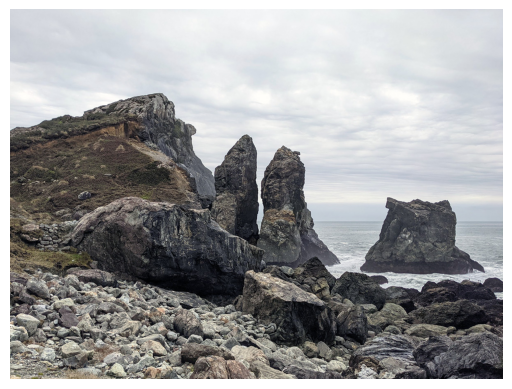

In [14]:
# 이미지 내려받기
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
									   "coast.jpg",
									   origin = 'https://img-datasets.s3.amazonaws.com/coast.jpg'
)
plt.axis('off')
plt.imshow(keras.utils.load_img(base_image_path))

In [15]:
# 사전 훈련 컨브넷 이용하기
from tensorflow.keras.applications import inception_v3

model = inception_v3.InceptionV3(weights = 'imagenet', include_top = False)

87910968/87910968 [==============================] - 0s 0us/step


In [31]:
# 다양한 중간 층의 활성화를 반환하는 추출 모델 만들기

# 활성화 최대화할 층과 전체 손실에 대한 가중치.
layer_settings = {
				  "mixed4" : 1.0,
				  "mixed5" : 1.5,
				  "mixed6" : 2.0,
				  "mixed7" : 2.5
}

# 각 층의 심볼릭 출력
outputs_dict = dict(
					[
					(layer.name, layer.output) for layer in [model.get_layer(name) for name in layer_settings.keys()]
					]
)

# 각 타깃의 활성화층을 하나의 딕셔너리로 반환
feature_extractor = keras.Model(inputs = model.inputs, outputs = outputs_dict)

In [38]:
# 손실 계산
def compute_loss(input_image):
	features = feature_extractor(input_image)
	loss = tf.zeros(shape = ()) # 초기화 : 0
	for name in features.keys():
		coeff = layer_settings[name]
		activation = features[name]
		# 테두리가 아닌 픽셀만 손실에 추가
		loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
	return loss

In [39]:
# 경사 상승법 단계

import tensorflow as tf

@tf.function # 속도 높이기
def gradient_ascent_step(image, learning_rate):
	# 현재 이미지에 대한 딥드림 손실 그래디언트 계산
	with tf.GradientTape() as tape:
		tape.watch(image)
		loss = compute_loss(image)
	grads = tape.gradient(loss, image)
	grads = tf.math.l2_normalize(grads) # 정규화
	image += learning_rate * grads
	return loss, image

# 주어진 이미지 스케일(옥타브)에 대한 경사 상승법 수행
def gradient_ascent_loop(image, iterations, learning_rate, max_loss = None):
	for i in range(iterations):
		loss, image = gradient_ascent_step(image, learning_rate)
		if max_loss is not None and loss > max_loss: # 손실이 임계값을 넘으면 중지 - 과도한 최적화 방지
			break
		print(f"... 스텝 {i}에서의 손실 값 : {loss:.2f}")
	return image

In [40]:
# 파라미터 정의
step = 20. # 경사 상승법 단계
num_octave = 3 # 경사 상승법 실행할 스케일 횟수
octave_scale = 1.4 # 연속적인 스케일 사이의 크기 비율
iterations = 30 # 스케일 단계마다 수행하는 경사 상승법 단계 횟수
max_loss = 15. # 손실 임계값 : 이거보다 크면 중지

# 이미지 로드 & 저장 유틸리티 함수
import numpy as np

# 이미지 -> 넘파이 변환
def preprocess_image(image_path):
	img = keras.utils.load_img(image_path)
	img = keras.utils.img_to_array(img)
	img = np.expand_dims(img, axis = 0)
	img = keras.applications.inception_v3.preprocess_input(img)
	return img

# 넘파이 -> 이미지 변환
def deprocess_image(img):
	img = img.reshape((img.shape[1], img.shape[2], 3))
	# InceptionV3 전처리 복원
	img += 1.0
	img *= 127.5
	img = np.clip(img, 0, 255).astype('uint8')
	return img

In [41]:
# 여러 옥타브에 걸쳐 경사 상승법 실행하기
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

# 여러 옥타브에서 이미지 크기 계산
successive_shapes = [original_shape]
for i in range(1, num_octave):
	shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
	successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

# 이미지 복사
img = tf.identity(original_img)

for i, shape in enumerate(successive_shapes):
	print(f"{shape} 크기와 {i}번째 옥타브 처리")
	img = tf.image.resize(img, shape) # 스케일을 높임
	img = gradient_ascent_loop(img, iterations = iterations, learning_rate = step, max_loss = max_loss) # 경사 상승법 실행, 이미지 수정
	upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
	same_size_original = tf.image.resize(original_img, shape) # 작은 버전의 원본 이미지 스케일 상승. 픽셀 경계가 보인다.
	lost_detail = same_size_original - upscaled_shrunk_original_img # 고해상도 원본 이미지 계산
	img += lost_detail # 손실된 디테일을 딥드림 이미지에 다시 넣음
	shrunk_origianl_img = tf.image.resize(original_img, shape)

keras.utils.save_img("dream.png", deprocess_image(img.numpy())) # 최종 결과 저장

(459, 612) 크기와 0번째 옥타브 처리
... 스텝 0에서의 손실 값 : 0.80
... 스텝 1에서의 손실 값 : 1.07
... 스텝 2에서의 손실 값 : 1.44
... 스텝 3에서의 손실 값 : 1.82
... 스텝 4에서의 손실 값 : 2.15
... 스텝 5에서의 손실 값 : 2.48
... 스텝 6에서의 손실 값 : 2.82
... 스텝 7에서의 손실 값 : 3.18
... 스텝 8에서의 손실 값 : 3.51
... 스텝 9에서의 손실 값 : 3.85
... 스텝 10에서의 손실 값 : 4.18
... 스텝 11에서의 손실 값 : 4.57
... 스텝 12에서의 손실 값 : 4.89
... 스텝 13에서의 손실 값 : 5.25
... 스텝 14에서의 손실 값 : 5.61
... 스텝 15에서의 손실 값 : 5.96
... 스텝 16에서의 손실 값 : 6.30
... 스텝 17에서의 손실 값 : 6.68
... 스텝 18에서의 손실 값 : 6.99
... 스텝 19에서의 손실 값 : 7.34
... 스텝 20에서의 손실 값 : 7.64
... 스텝 21에서의 손실 값 : 7.98
... 스텝 22에서의 손실 값 : 8.26
... 스텝 23에서의 손실 값 : 8.54
... 스텝 24에서의 손실 값 : 8.88
... 스텝 25에서의 손실 값 : 9.14
... 스텝 26에서의 손실 값 : 9.45
... 스텝 27에서의 손실 값 : 9.68
... 스텝 28에서의 손실 값 : 10.00
... 스텝 29에서의 손실 값 : 10.24
(642, 857) 크기와 1번째 옥타브 처리
... 스텝 0에서의 손실 값 : 1.59
... 스텝 1에서의 손실 값 : 2.63
... 스텝 2에서의 손실 값 : 3.46
... 스텝 3에서의 손실 값 : 4.06
... 스텝 4에서의 손실 값 : 4.59
... 스텝 5에서의 손실 값 : 5.06
... 스텝 6에서의 손실 값 : 5.56
... 스텝 7에서의 손실 값 : 5.95
... 스텝 8에서의 손실

## 뉴럴 스타일 트랜스퍼

In [68]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

In [69]:
# 유틸리티 함수 : 이미지 <-> 배열
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

# 넘파이 -> 이미지 변환
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [70]:
# VGG19 네트워크 준비
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [71]:
# 컨텐츠 손실 정의
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [72]:
# 스타일 손실 정의
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [73]:
# 총 변위 손실 정의
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [74]:
# 최소화할 최종 손실 정의하기
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    
    # 컨텐츠 손실을 더함
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    
    # 스타일 손실을 더함
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value
        
    # 총 변위 손실을 더함
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [75]:
# 경사 하강법 단계 설정하기
# 원 논문은 L-BFGS 알고리즘을 쓰나, 여기서는 SGD와 학습률 감소를 씀
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"{i}번째 반복: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

100번째 반복: loss=8138.44
200번째 반복: loss=6653.06
300번째 반복: loss=6063.13
400번째 반복: loss=5742.33
500번째 반복: loss=5535.54
600번째 반복: loss=5389.57
700번째 반복: loss=5279.96
800번째 반복: loss=5194.20
900번째 반복: loss=5125.06
1000번째 반복: loss=5068.19
1100번째 반복: loss=5020.50
1200번째 반복: loss=4979.74
1300번째 반복: loss=4944.42
1400번째 반복: loss=4913.52
1500번째 반복: loss=4886.31
1600번째 반복: loss=4862.13
1700번째 반복: loss=4840.65
1800번째 반복: loss=4821.46
1900번째 반복: loss=4804.22
2000번째 반복: loss=4788.60
2100번째 반복: loss=4774.41
2200번째 반복: loss=4761.43
2300번째 반복: loss=4749.47
2400번째 반복: loss=4738.44
2500번째 반복: loss=4728.26
2600번째 반복: loss=4718.82
2700번째 반복: loss=4710.02
2800번째 반복: loss=4701.85
2900번째 반복: loss=4694.25
3000번째 반복: loss=4687.16
3100번째 반복: loss=4680.55
3200번째 반복: loss=4674.37
3300번째 반복: loss=4668.59
3400번째 반복: loss=4663.17
3500번째 반복: loss=4658.09
3600번째 반복: loss=4653.29
3700번째 반복: loss=4648.77
3800번째 반복: loss=4644.51
3900번째 반복: loss=4640.51
4000번째 반복: loss=4636.73


## 케라스로 VAE 구현하기

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

# 잠재 공간 차원
latent_dim = 2

# 인코더
encoder_inputs = keras.Input(shape = (28, 28, 1))
x = layers.Conv2D(32, 3, activation = 'relu', strides = 2, padding = 'same')(encoder_inputs)
x = layers.Conv2D(64, 3, activation = 'relu', strides = 2, padding = 'same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation = 'relu')(x)
z_mean = layers.Dense(latent_dim, name = "z_mean")(x)
z_log_var = layers.Dense(latent_dim, name = "z_log_var")(x)

# 마지막엔 2개의 파라미터를 반환해야 하므로
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name = 'encoder') 

In [3]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

In [4]:
# 샘플링
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape = (batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
# VAE 디코더
latent_inputs = keras.Input(shape = (latent_dim, ))
x = layers.Dense(7 * 7 * 64, activation = 'relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = layers.Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name = 'decoder')

In [15]:
# VAE 모델 만들기
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        
        # 에포크마다 손실 평균 추적
        self.total_loss_tracker = keras.metrics.Mean(name = 'total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name = "reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name = "kl_loss")
        
    @property
    def metrics(self):
        """
        각 에포크 완료 후 or fit()과 evaluate() 사이에 \
        모델이 손실을 재설정할 수 있도록 metrics 속성에 손실을 나열함
        """
        return [self.total_loss_tracker,
               self.reconstruction_loss_tracker,
               self.kl_loss_tracker]
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # 공간 차원(축 1, 2)에 대해 재구성 손실을 더한 뒤, 배치 차원에 대해 평균을 계산한다
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction),
                                                              axis = (1, 2)
                                                              )
                                                )
            # 규제항(쿨백-라이블러 발산)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            'total_loss' : self.total_loss_tracker.result(),
            'reconstruction_loss' : self.reconstruction_loss_tracker.result(),
            'kl_loss' : self.kl_loss_tracker.result()
        }

In [16]:
# VAE 훈련
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis = 0) # MNIST 전체 데이터를 쓸 거임(훈련 + 테스트)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer = keras.optimizers.Adam(), run_eagerly = True) # 손실은 `train_step()`에서 처리하므로 지정 X
vae.fit(mnist_digits, epochs = 30, batch_size = 128)

Epoch 1/30
547/547 [==============================] - 30s 49ms/step - total_loss: 212.1333 - reconstruction_loss: 210.7506 - kl_loss: 1.3825
Epoch 2/30
547/547 [==============================] - 27s 50ms/step - total_loss: 173.2013 - reconstruction_loss: 170.0426 - kl_loss: 3.1586
Epoch 3/30
547/547 [==============================] - 26s 48ms/step - total_loss: 161.1211 - reconstruction_loss: 157.8332 - kl_loss: 3.2880
Epoch 4/30
547/547 [==============================] - 27s 49ms/step - total_loss: 157.5476 - reconstruction_loss: 154.1920 - kl_loss: 3.3555
Epoch 5/30
547/547 [==============================] - 27s 49ms/step - total_loss: 155.5707 - reconstruction_loss: 152.1432 - kl_loss: 3.4275
Epoch 6/30
547/547 [==============================] - 27s 49ms/step - total_loss: 154.4418 - reconstruction_loss: 150.9570 - kl_loss: 3.4847
Epoch 7/30
547/547 [==============================] - 27s 49ms/step - total_loss: 153.3081 - reconstruction_loss: 149.8101 - kl_loss: 3.4979
Epoch 8/30
54

1/1 [==============================] - 0s 20ms/step


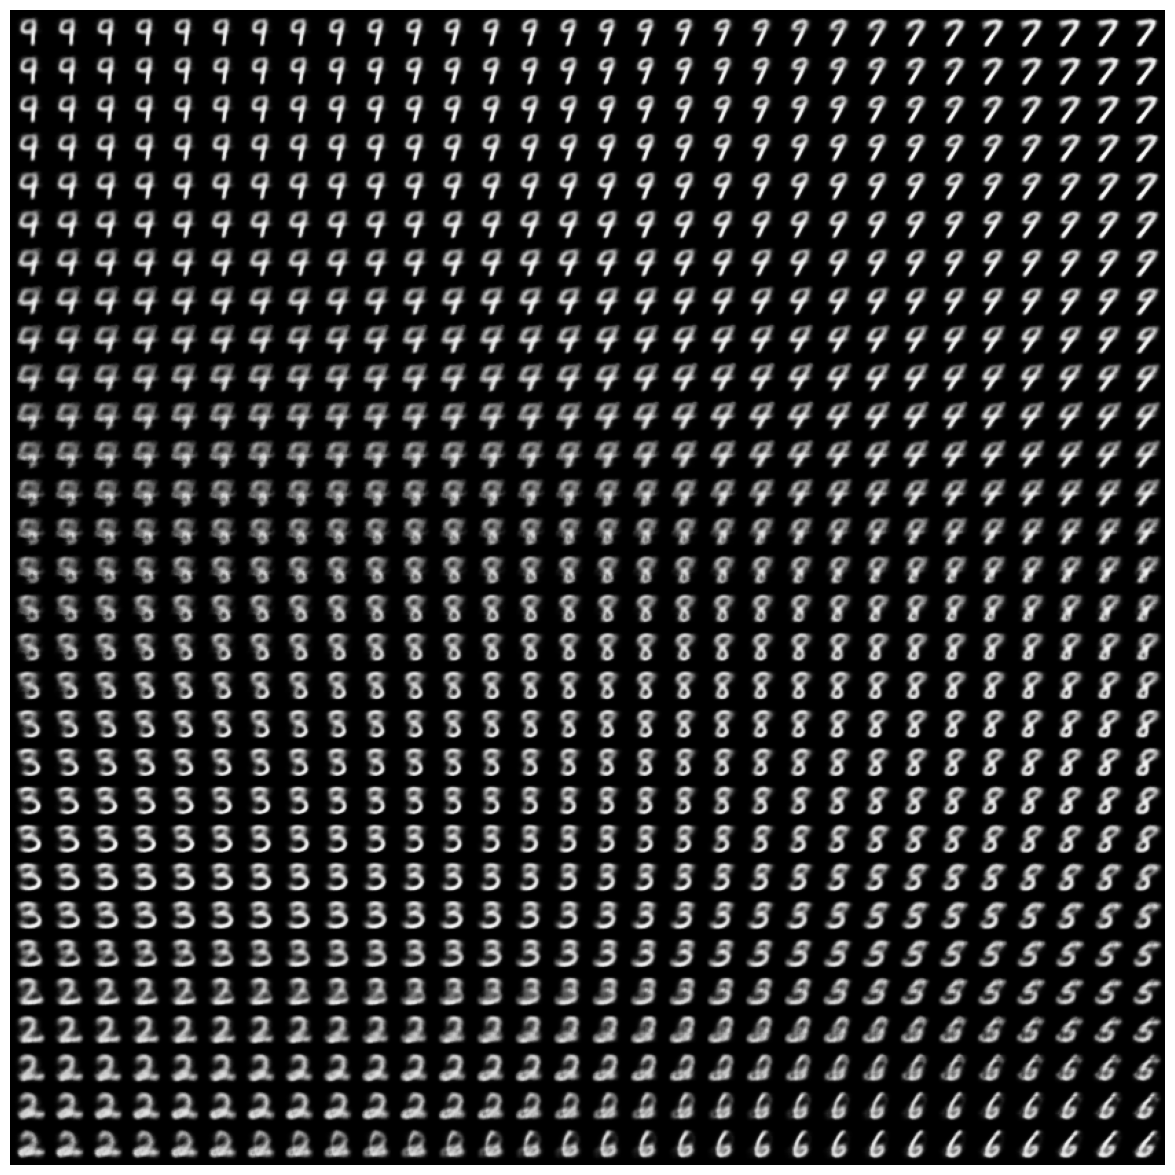

In [18]:
# 2D 잠재 공간에서 이미지 그리드 샘플링
import matplotlib.pyplot as plt

n = 30 # 30 x 30 그리드
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# 2D 그리드, 선형적으로 포인트 샘플링
grid_x = np.linspace(-1, 1 , n)
grid_y = np.linspace(-1, 1, n)[::-1]


for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        
        # 각 위치의 숫자 샘플링해서 그림에 추가
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample) 
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size
        ] = digit
        
plt.figure(figsize = (15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis('off')
plt.imshow(figure, cmap = 'Greys_r')

## GAN

In [20]:
# 데이터셋 준비
!mkdir celeba_gan
!pip install gdown
!gdown 1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9 -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

mkdir: cannot create directory ‘celeba_gan’: File exists
Downloading...
From (uriginal): https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9
From (redirected): https://drive.google.com/uc?id=1up5bN8LCE2vHigVY-Z9yY2_aKRW5jN_9&confirm=t&uuid=4e977119-2971-497c-97c1-1df7e4ae1038
To: /kaggle/working/celeba_gan/data.zip
100%|██████████████████████████████████████| 1.44G/1.44G [00:17<00:00, 80.7MB/s]


Found 202599 files belonging to 1 classes.


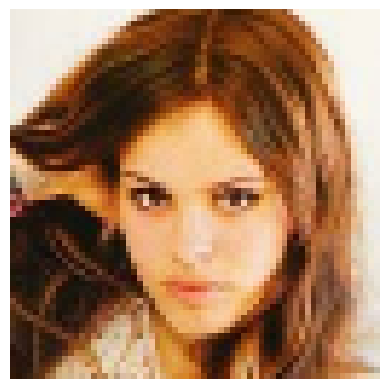

In [22]:
from tensorflow import keras

dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode = None, # 레이블 x, 이미지만 반환
    image_size = (64, 64),
    batch_size = 32,
    smart_resize = True # 이미지 변환 시 가로세로 비율을 유지해준다
)

dataset = dataset.map(lambda x: x / 255.) # 0-1 범위로 조정

# 샘플 이미지 출력
# import matplotlib.pyplot as plt

# for x in dataset:
#     plt.axis('off')
#     plt.imshow((x.numpy() * 255).astype('int32')[0])
#     break
    

In [23]:
# 판별자 구현
from tensorflow.keras import layers

discriminator = keras.Sequential(
[
    keras.Input(shape = (64, 64, 3)),
    layers.Conv2D(64, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(alpha = 0.2), 
    layers.Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(alpha = 0.2), 
    layers.Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(alpha = 0.2), 
    layers.Flatten(),
    layers.Dropout(0.2), # 중요!
    layers.Dense(1, activation = 'sigmoid')
],
name = 'discriminator'
)

In [25]:
# 생성자 구현
latent_dim = 128 # 잠재 공간은 128차원 벡터

generator = keras.Sequential([
    keras.Input(shape = (latent_dim,)),
    layers.Dense(8 * 8 * 128), # 판별자의 Flatten() 층의 출력 크기와 동일하게 지정
    layers.Reshape((8, 8, 128)), # Flatten() 층 되돌리기
    layers.Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(alpha = 0.2),
    layers.Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(alpha = 0.2),
    layers.Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(alpha = 0.2),
    layers.Conv2D(3, kernel_size = 5, padding = 'same', activation = 'sigmoid'),
],
name = 'generator',
)

In [35]:
# 적대 네트워크
import tensorflow as tf

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name = "d_loss")
        self.g_loss_metric = keras.metrics.Mean(name = 'g_loss')
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        # 잠재 공간에서 랜덤 포인트 샘플링
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape = (batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors) # 랜덤 포인트 -> 가짜 이미지 인코딩
        combined_images = tf.concat([generated_images, real_images], axis = 0) # 가짜와 진짜 이미지 합침
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis = 0) # 가짜와 진짜 이미지 레이블 합침
        labels += 0.05 * tf.random.uniform(tf.shape(labels)) # 레이블에 랜덤 잡음 추가
        
        # 판별자 훈련
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        random_latent_vectors = tf.random.normal(shape = (batch_size, self.latent_dim)) # 랜덤 포인트 샘플링
        misleading_labels = tf.zeros((batch_size, 1)) # 모두 진짜라고 말하는 레이블 만들기(실제로는 아님)
        
        # 생성자 훈련
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {'d_loss' : self.d_loss_metric.result(),
               'g_loss' : self.g_loss_metric.result()}

In [36]:
# 훈련 중 이미지 생성하는 콜백함수
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img = 3, latent_dim = 128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs = None):
        random_latent_vectors = tf.random.normal(shape = (self.num_img, self.latent_dim))
        generated_images = self.model_generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [ ]:
# GAN 모델 컴파일 및 훈련
epochs = 100

gan = GAN(discriminator = discriminator, generator = generator, latent_dim = latent_dim)

gan.compile(d_optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
           g_optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
           loss_fn = keras.losses.BinaryCrossentropy())

gan.fit(dataset, epochs = epochs,
       callbacks = [GANMonitor(num_img = 10, latent_dim = latent_dim)])

Epoch 1/100
1367/6332 [=====>........................] - ETA: 23:50 - d_loss: 0.5343 - g_loss: 1.5681